# MLP Regression on Cantilever Beam Data

## Objectives

In this exercise, we shall: 
- Build and train a simple multi-layer perceptron (MLP) to predict displacements $(u_x, u_y)$ from coordinates $(x, y)$. 
- Perform train-test-validation, grid-search hyperparamter search using sklearn
- Compare MLP accuracy agains interpolation methods from ```scipy.interpolate.griddata```

## Problem Setup
A 2D cantilever beam is modeled under small-strain, plane-strain conditions with linear-elastic behaviour:

- Length $L$ = 1.0 m, Height $H$ = 0.1 m. 
- Young's Modulus $E$ = 210 GPa, Poisson's ratio $\nu$ = 0.3
- Constitutive Law: Hooke's law with Lame` coefficients:
    $\sigma = \lambda tr(\varepsilon)I + 2 \mu \varepsilon, $
- Load: vertical tip load $P = 10^7 N$ is applied
- Data: 500 random collocation points form the FEM displacement field:
    - $(x, y, u_x, u_y)$ are used

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

### Load Data & minimal EDA

In [147]:
# load data
data = pd.read_csv("collocation_linear.csv")
data.head()


,x,y,u_x,u_y,eps_xx,eps_yy,gamma_xy,sigma_xx,sigma_yy,sigma_xy
0,0.936923,0.066693,0.003758,-0.137362,0.000493,-0.000159,-0.000677,1.201380e+08,1.468900e+07,-5.471081e+07
1,0.930191,0.020165,-0.006714,-0.135846,-0.000997,0.000337,-0.001232,-2.411499e+08,-2.563624e+07,-9.949554e+07
2,0.390042,0.025915,-0.003411,-0.030205,-0.006844,0.002971,0.003032,-1.574743e+09,1.077775e+07,2.448636e+08
3,0.552140,0.055487,0.000991,-0.056597,0.001060,-0.002182,-0.005750,3.541303e+07,-4.882722e+08,-4.644431e+08
4,0.730129,0.056415,0.001345,-0.091807,0.000802,-0.001315,-0.000687,6.747795e+07,-2.744388e+08,-5.552037e+07


In [148]:
# inputs: x, y, target: ux, uy
X, y = data[["x", "y"]], data[["u_x", "u_y"]]
# split test train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 450, Test size: 50


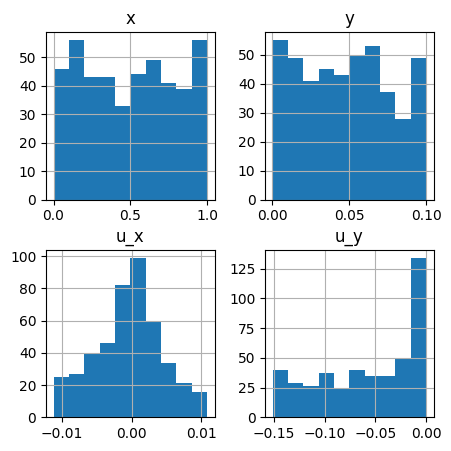

In [149]:
pd.concat((X_train, y_train)).hist(figsize=(5, 5), bins=10)
plt.show()



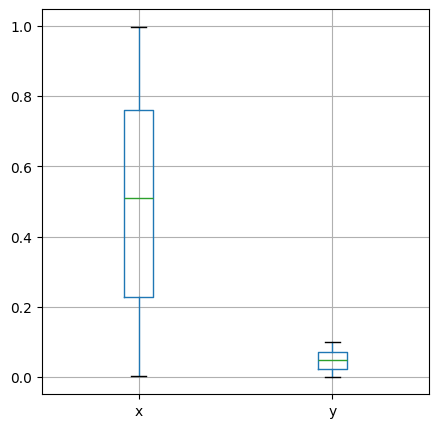

In [150]:
X_train.boxplot(figsize=(5, 5))
plt.show()

Data does not have any outliers. However, the inputs have very different scales

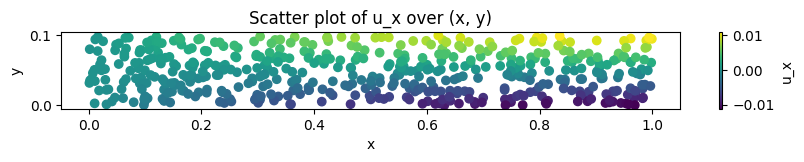

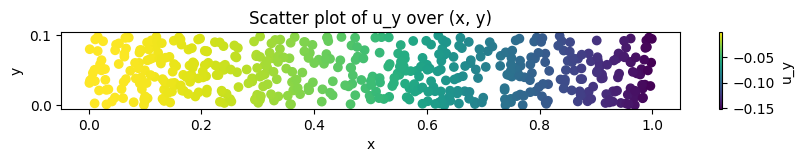

In [151]:
# plot targets
for col in pd.concat((X_train, y_train)).columns[2:]:
    len_x = data["x"].max() - data["x"].min()
    len_y = data["y"].max() - data["y"].min()
    plt.figure(figsize=(10*len_x, 10*len_y))
    plt.scatter(data["x"], data["y"], c=data[col])
    plt.colorbar(label=col)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Scatter plot of {col} over (x, y)")
    plt.show()

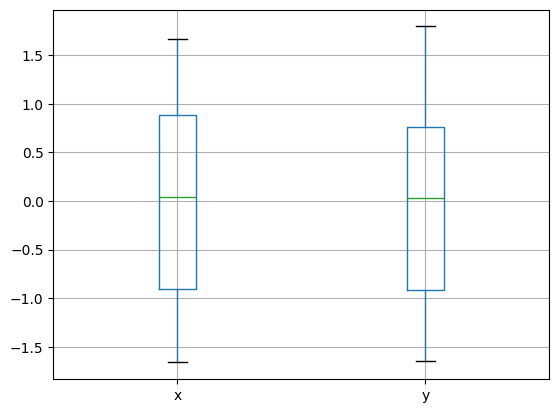

In [152]:
# Scale data 
scaler = StandardScaler()
# scale inputs
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = ["x", "y"])
X_train_scaled.boxplot()
plt.show()


Now, the scaled data has both inputs are in the same scale

In [153]:
from sklearn.neural_network import MLPRegressor
# parameters for the model
params ={
    "solver": "adam",
    "learning_rate": "constant",
    "learning_rate_init": 1e-3,
    "activate_function": "relu",
    "tol": 1e-8,
    "hidden_layer_sizes": (100,), 
    "max_iter": 1000
}

def create_MLPRegressor(params):
    mlp = MLPRegressor(
        solver=params["solver"],
        learning_rate=params["learning_rate"],
        learning_rate_init=params["learning_rate_init"],
        activation=params.get("activate_function", "relu"),
        tol=params["tol"],
        hidden_layer_sizes=params["hidden_layer_sizes"], 
        max_iter = params["max_iter"]
    
    )
    return mlp

model = create_MLPRegressor(params)
model


MLPRegressor(max_iter=1000, tol=1e-08)

In [154]:
# fit model on train data
model.fit(X_train_scaled, y_train)

MLPRegressor(max_iter=1000, tol=1e-08)

In [155]:
# predict using model
y_pred = model.predict(pd.DataFrame(scaler.transform(X_test), columns=["x", "y"]))

In [156]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
mse = mean_squared_error(y_pred, y_test)
mape = mean_absolute_percentage_error(y_pred, y_test)
print(mse)
print(mape)

7.160280129440367e-06
0.8988442562530907


In [157]:
 # use grid_searchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    "solver": ["adam", "sgd", "lbfgs"],
    "learning_rate_init": [1e-2, 1e-4, 1e-6],
    "activation": ["relu","tanh"],
    "hidden_layer_sizes": [(100,), (100, 100,), (100, 100, 100, )], 
}

def hyperparameter_tuning(X_train, y_train, param_grid):
    mlp_cv = MLPRegressor()
    grid_search = GridSearchCV(estimator=mlp_cv,
                               param_grid=param_grid,
                               cv=3,
                               n_jobs=4,
                               scoring = "neg_mean_squared_error",
                               )
    grid_search.fit(X_train, y_train)
    return grid_search

In [158]:
# set mflow tracking of experiments
import mlflow
import mlflow.sklearn

from mlflow.models import infer_signature
from urllib.parse import urlparse

# Define MLFlow Experiment
mlflow.set_experiment("MLP_Cantilever_Beam_Regression3")

# Perform hyperparameter search first
print("Performing hyperparameter tuning...")
grid_search = hyperparameter_tuning(X_train_scaled, y_train, param_grid)

# Get all CV results
cv_results = grid_search.cv_results_
print(f"Grid search completed. Testing {len(cv_results['params'])} parameter combinations...")

# Prepare test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=["x", "y"])
signature = infer_signature(X_train_scaled, y_train)

# Log all individual models from grid search
for i in range(len(cv_results['params'])):
    with mlflow.start_run(run_name=f"MLP_Model_{i+1}"):
        # Get parameters for this model
        params = cv_results['params'][i]
        
        # Create and train model with these exact parameters
        model = MLPRegressor(
            solver=params["solver"],
            learning_rate_init=params["learning_rate_init"],
            activation=params["activation"],
            hidden_layer_sizes=params["hidden_layer_sizes"],
            max_iter=1000,
            random_state=42
        )
        
        # Fit the model
        model.fit(X_train_scaled, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        # Log parameters
        mlflow.log_param("solver", params["solver"])
        mlflow.log_param("learning_rate_init", params["learning_rate_init"])
        mlflow.log_param("activation", params["activation"])
        mlflow.log_param("hidden_layer_sizes", str(params["hidden_layer_sizes"]))
        
        # Log metrics
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mape", mape)
        mlflow.log_metric("cv_mean_score", -cv_results['mean_test_score'][i])  # Convert from negative MSE
        mlflow.log_metric("cv_std_score", cv_results['std_test_score'][i])
        
        # Log model
        mlflow.sklearn.log_model(model, "model", signature=signature)
        
        print(f"Model {i+1:2d}: solver={params['solver']:6s}, lr={params['learning_rate_init']:.0e}, "
              f"activation={params['activation']:4s}, layers={str(params['hidden_layer_sizes']):15s} "
              f"-> MSE: {mse:.6f}, MAPE: {mape:.4f}")

# Log best model separately with special identifier
with mlflow.start_run(run_name="BEST_MLP_Model"):
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Predict on test set
    y_pred_best = best_model.predict(X_test_scaled)
    
    # Calculate metrics
    best_mse = mean_squared_error(y_test, y_pred_best)
    best_mape = mean_absolute_percentage_error(y_test, y_pred_best)
    
    # Log parameters with "best_" prefix
    for param_name, param_value in best_params.items():
        mlflow.log_param(f"best_{param_name}", param_value)
    
    # Log metrics
    mlflow.log_metric("mse", best_mse)
    mlflow.log_metric("mape", best_mape)
    mlflow.log_metric("cv_best_score", -grid_search.best_score_)
    
    # Set special tags for identification
    mlflow.set_tag("model_type", "best_model")
    mlflow.set_tag("is_best", "true")
    
    # Log model
    mlflow.sklearn.log_model(best_model, "best_model", 
                            signature=signature,
                            registered_model_name="Best_MLP_Cantilever_Regressor")
    
    print(f"\n{'='*60}")
    print(f"BEST MODEL RESULTS:")
    print(f"{'='*60}")
    print(f"Best Hyperparams: {best_params}")
    print(f"Best CV Score: {-grid_search.best_score_:.6f}")
    print(f"Test MSE: {best_mse:.6f}")
    print(f"Test MAPE: {best_mape:.4f}")
    print(f"{'='*60}")

print(f"\nSUMMARY: {len(cv_results['params'])} models tracked in MLflow!")
print("Access MLflow UI at: http://127.0.0.1:8080")




Performing hyperparameter tuning...
Grid search completed. Testing 54 parameter combinations...
Grid search completed. Testing 54 parameter combinations...


2025/09/14 17:48:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model  1: solver=adam  , lr=1e-02, activation=relu, layers=(100,)          -> MSE: 0.000081, MAPE: 8.2500
🏃 View run MLP_Model_1 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/7ffab0b6365347639bccb01d5f8a0aca
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:48:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model  2: solver=sgd   , lr=1e-02, activation=relu, layers=(100,)          -> MSE: 0.000535, MAPE: 29.0733
🏃 View run MLP_Model_2 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/cfe8c540c3ac42169daea159f921dddb
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:48:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model  3: solver=lbfgs , lr=1e-02, activation=relu, layers=(100,)          -> MSE: 0.000023, MAPE: 4.2088
🏃 View run MLP_Model_3 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/2193c5cf533e43a880effff1dd1f4072
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:48:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model  4: solver=adam  , lr=1e-04, activation=relu, layers=(100,)          -> MSE: 0.003204, MAPE: 34.6358
🏃 View run MLP_Model_4 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/bc94e434ed84483a9670f3e0f6e61799
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:48:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model  5: solver=sgd   , lr=1e-04, activation=relu, layers=(100,)          -> MSE: 0.013584, MAPE: 27.6592
🏃 View run MLP_Model_5 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/8cbc71a85c464aeeb0d6164f085a4e07
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:48:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model  6: solver=lbfgs , lr=1e-04, activation=relu, layers=(100,)          -> MSE: 0.000023, MAPE: 4.2088
🏃 View run MLP_Model_6 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/11e925b86e2a405da6ebc369c75e6949
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:48:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model  7: solver=adam  , lr=1e-06, activation=relu, layers=(100,)          -> MSE: 0.047547, MAPE: 46.1922
🏃 View run MLP_Model_7 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/9f7757bf609d4c97ba85e1d2507a8f46
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model  8: solver=sgd   , lr=1e-06, activation=relu, layers=(100,)          -> MSE: 0.047694, MAPE: 46.5509
🏃 View run MLP_Model_8 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/49845f7ed45c40e9aa128a8be1001d9d
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:48:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model  9: solver=lbfgs , lr=1e-06, activation=relu, layers=(100,)          -> MSE: 0.000023, MAPE: 4.2088
🏃 View run MLP_Model_9 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/f8c408cb6ac94f04be14fb76491b8d25
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:48:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 10: solver=adam  , lr=1e-02, activation=relu, layers=(100, 100)      -> MSE: 0.000035, MAPE: 4.8849
🏃 View run MLP_Model_10 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/6c3e0eaba669429f9a84a604b048984c
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:49:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 11: solver=sgd   , lr=1e-02, activation=relu, layers=(100, 100)      -> MSE: 0.000403, MAPE: 11.1051
🏃 View run MLP_Model_11 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/26fad065149d48f594d53c1fcae12c77
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:49:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 12: solver=lbfgs , lr=1e-02, activation=relu, layers=(100, 100)      -> MSE: 0.000026, MAPE: 4.8109
🏃 View run MLP_Model_12 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/9cab9b3ea28f4dfa83f91b3d63d5f02e
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:49:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 13: solver=adam  , lr=1e-04, activation=relu, layers=(100, 100)      -> MSE: 0.000436, MAPE: 16.7918
🏃 View run MLP_Model_13 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/854edaaeb020462ea684847f71d96525
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:49:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 14: solver=sgd   , lr=1e-04, activation=relu, layers=(100, 100)      -> MSE: 0.014763, MAPE: 97.8594
🏃 View run MLP_Model_14 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/992327e6c09f426497cf34eff399b35b
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:49:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 15: solver=lbfgs , lr=1e-04, activation=relu, layers=(100, 100)      -> MSE: 0.000026, MAPE: 4.8109
🏃 View run MLP_Model_15 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/527b3fbc8bf24e7faa365fb94ebd7193
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:49:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 16: solver=adam  , lr=1e-06, activation=relu, layers=(100, 100)      -> MSE: 0.024113, MAPE: 143.5028
🏃 View run MLP_Model_16 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/689e7185e03949abbd591cc86dad996f
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:50:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 17: solver=sgd   , lr=1e-06, activation=relu, layers=(100, 100)      -> MSE: 0.024549, MAPE: 145.3361
🏃 View run MLP_Model_17 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/790626d798b944b8ba91b6ae39309190
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:50:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 18: solver=lbfgs , lr=1e-06, activation=relu, layers=(100, 100)      -> MSE: 0.000026, MAPE: 4.8109
🏃 View run MLP_Model_18 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/bb5f7fa991b94d7493ffa2754d1a6b5f
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:50:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 19: solver=adam  , lr=1e-02, activation=relu, layers=(100, 100, 100) -> MSE: 0.000026, MAPE: 5.5118
🏃 View run MLP_Model_19 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/619a27b231bc46958ec1498ff0ff9625
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:50:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 20: solver=sgd   , lr=1e-02, activation=relu, layers=(100, 100, 100) -> MSE: 0.000186, MAPE: 10.6931
🏃 View run MLP_Model_20 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/7c0527bab76041ac92c44dbeb08d33da
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:50:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 21: solver=lbfgs , lr=1e-02, activation=relu, layers=(100, 100, 100) -> MSE: 0.000013, MAPE: 4.3741
🏃 View run MLP_Model_21 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/f1b7074de2124ab1a36887e576491650
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:50:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 22: solver=adam  , lr=1e-04, activation=relu, layers=(100, 100, 100) -> MSE: 0.000485, MAPE: 28.1017
🏃 View run MLP_Model_22 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/a75f66b34f7f44e8b2fdc241906bb7e9
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:50:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 23: solver=sgd   , lr=1e-04, activation=relu, layers=(100, 100, 100) -> MSE: 0.012305, MAPE: 105.9900
🏃 View run MLP_Model_23 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/1fa0f890f34e459cb2594d9408ee6e44
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:50:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 24: solver=lbfgs , lr=1e-04, activation=relu, layers=(100, 100, 100) -> MSE: 0.000013, MAPE: 4.3741
🏃 View run MLP_Model_24 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/330db401c2754377919189892b9dec74
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:50:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 25: solver=adam  , lr=1e-06, activation=relu, layers=(100, 100, 100) -> MSE: 0.062626, MAPE: 295.9570
🏃 View run MLP_Model_25 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/f6666795126c43c5a3a359e4a0755136
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:50:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 26: solver=sgd   , lr=1e-06, activation=relu, layers=(100, 100, 100) -> MSE: 0.063603, MAPE: 298.5020
🏃 View run MLP_Model_26 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/1514b49879c44e4aa0d3c605273899cd
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:50:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 27: solver=lbfgs , lr=1e-06, activation=relu, layers=(100, 100, 100) -> MSE: 0.000013, MAPE: 4.3741
🏃 View run MLP_Model_27 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/164fd0752c5f40b18216bb20d818680b
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 28: solver=adam  , lr=1e-02, activation=tanh, layers=(100,)          -> MSE: 0.000068, MAPE: 10.2555
🏃 View run MLP_Model_28 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/e888addbb9d74fb5ad139bf1a1eceb23
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 29: solver=sgd   , lr=1e-02, activation=tanh, layers=(100,)          -> MSE: 0.000093, MAPE: 7.9822
🏃 View run MLP_Model_29 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/ed98c34464e64e1990f4ab80dc294bad
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 30: solver=lbfgs , lr=1e-02, activation=tanh, layers=(100,)          -> MSE: 0.000002, MAPE: 0.9147
🏃 View run MLP_Model_30 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/defc89f618e44989bdb444b22aef947f
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 31: solver=adam  , lr=1e-04, activation=tanh, layers=(100,)          -> MSE: 0.000245, MAPE: 13.6823
🏃 View run MLP_Model_31 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/e5da53160e104111b0fa8ffc2858ee92
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 32: solver=sgd   , lr=1e-04, activation=tanh, layers=(100,)          -> MSE: 0.005078, MAPE: 74.3931
🏃 View run MLP_Model_32 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/27d224bf6c364b828442148ea0ffe99d
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 33: solver=lbfgs , lr=1e-04, activation=tanh, layers=(100,)          -> MSE: 0.000002, MAPE: 0.9147
🏃 View run MLP_Model_33 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/669edc75643c4336b24250a8ca7aeb5c
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 34: solver=adam  , lr=1e-06, activation=tanh, layers=(100,)          -> MSE: 0.030480, MAPE: 201.8266
🏃 View run MLP_Model_34 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/3afd9bf5125f4e1694e065ddec7bdf10
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 35: solver=sgd   , lr=1e-06, activation=tanh, layers=(100,)          -> MSE: 0.030706, MAPE: 202.5086
🏃 View run MLP_Model_35 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/2c438377c2ff47c7b5115b9a89aae0cf
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 36: solver=lbfgs , lr=1e-06, activation=tanh, layers=(100,)          -> MSE: 0.000002, MAPE: 0.9147
🏃 View run MLP_Model_36 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/f96eca8c5aaa46f491b96a8e02f1a8b5
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 37: solver=adam  , lr=1e-02, activation=tanh, layers=(100, 100)      -> MSE: 0.000051, MAPE: 3.4577
🏃 View run MLP_Model_37 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/2cf1ed0fae094818a5eb05bdf03188dd
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 38: solver=sgd   , lr=1e-02, activation=tanh, layers=(100, 100)      -> MSE: 0.000210, MAPE: 9.9951
🏃 View run MLP_Model_38 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/014de171f02d43d88c7c4bfd9fea588f
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:51:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 39: solver=lbfgs , lr=1e-02, activation=tanh, layers=(100, 100)      -> MSE: 0.000008, MAPE: 1.6383
🏃 View run MLP_Model_39 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/3e8b22451847413ca0fd3d59da940bc9
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:52:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 40: solver=adam  , lr=1e-04, activation=tanh, layers=(100, 100)      -> MSE: 0.000248, MAPE: 11.0214
🏃 View run MLP_Model_40 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/d5c9f67500014dc5ab9131c5a78b8aa7
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:52:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 41: solver=sgd   , lr=1e-04, activation=tanh, layers=(100, 100)      -> MSE: 0.003237, MAPE: 52.1194
🏃 View run MLP_Model_41 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/720958b120c043b7b8bc30488c8232ad
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:52:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 42: solver=lbfgs , lr=1e-04, activation=tanh, layers=(100, 100)      -> MSE: 0.000008, MAPE: 1.6383
🏃 View run MLP_Model_42 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/5a3b98515e45441abc22bfe6f4e73670
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:52:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 43: solver=adam  , lr=1e-06, activation=tanh, layers=(100, 100)      -> MSE: 0.072092, MAPE: 317.0017
🏃 View run MLP_Model_43 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/0691b3857927486885a84bbf1153002c
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:52:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 44: solver=sgd   , lr=1e-06, activation=tanh, layers=(100, 100)      -> MSE: 0.074085, MAPE: 321.5615
🏃 View run MLP_Model_44 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/1c3c72e4c15147728e607350d3acc634
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:52:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 45: solver=lbfgs , lr=1e-06, activation=tanh, layers=(100, 100)      -> MSE: 0.000008, MAPE: 1.6383
🏃 View run MLP_Model_45 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/562698bccf124941857071788af5dc1c
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:53:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 46: solver=adam  , lr=1e-02, activation=tanh, layers=(100, 100, 100) -> MSE: 0.000041, MAPE: 5.0443
🏃 View run MLP_Model_46 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/621c54b96a5a42449738ec897aa5e38d
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:53:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 47: solver=sgd   , lr=1e-02, activation=tanh, layers=(100, 100, 100) -> MSE: 0.000151, MAPE: 11.2455
🏃 View run MLP_Model_47 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/4f54b1df784342d494501a093e23b6f8
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:53:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 48: solver=lbfgs , lr=1e-02, activation=tanh, layers=(100, 100, 100) -> MSE: 0.000010, MAPE: 1.9468
🏃 View run MLP_Model_48 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/e33f7d92ed9349648c7358056c627795
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:53:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 49: solver=adam  , lr=1e-04, activation=tanh, layers=(100, 100, 100) -> MSE: 0.000262, MAPE: 16.0409
🏃 View run MLP_Model_49 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/34ab1bd506044b0faf3258d27108db84
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:53:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 50: solver=sgd   , lr=1e-04, activation=tanh, layers=(100, 100, 100) -> MSE: 0.001998, MAPE: 19.3354
🏃 View run MLP_Model_50 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/d327ddec29ad416dae0c2bd077ce36f5
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:53:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 51: solver=lbfgs , lr=1e-04, activation=tanh, layers=(100, 100, 100) -> MSE: 0.000010, MAPE: 1.9468
🏃 View run MLP_Model_51 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/e600347d1e3a40dfac0f4ccd8fc247d7
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:54:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 52: solver=adam  , lr=1e-06, activation=tanh, layers=(100, 100, 100) -> MSE: 0.045125, MAPE: 141.9707
🏃 View run MLP_Model_52 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/41fbfd08a92845e2b6ded0c4d95f4214
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:54:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 53: solver=sgd   , lr=1e-06, activation=tanh, layers=(100, 100, 100) -> MSE: 0.231443, MAPE: 338.3847
🏃 View run MLP_Model_53 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/9cd7f8aaf3d84dd1b0d97a0611d1de25
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:54:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 54: solver=lbfgs , lr=1e-06, activation=tanh, layers=(100, 100, 100) -> MSE: 0.000010, MAPE: 1.9468
🏃 View run MLP_Model_54 at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/fbdc91eb96294684b43dd4d4e335034f
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774


2025/09/14 17:54:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'Best_MLP_Cantilever_Regressor' already exists. Creating a new version of this model...
2025/09/14 17:54:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_MLP_Cantilever_Regressor, version 3
Registered model 'Best_MLP_Cantilever_Regressor' already exists. Creating a new version of this model...
2025/09/14 17:54:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_MLP_Cantilever_Regressor, version 3
Created version '3' of model 'Best_MLP_Cantilever_Regressor'.
Created version '3' of model 'Best_MLP_Cantilever_Regressor'.



BEST MODEL RESULTS:
Best Hyperparams: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 1e-06, 'solver': 'lbfgs'}
Best CV Score: 0.000006
Test MSE: 0.000007
Test MAPE: 2.9361
🏃 View run BEST_MLP_Model at:  http://127.0.0.1:8080/#/experiments/981756139167564774/runs/aa35d80599364ac1bc4224423f8f2111
🧪 View experiment at:  http://127.0.0.1:8080/#/experiments/981756139167564774

SUMMARY: 54 models tracked in MLflow!
Access MLflow UI at: http://127.0.0.1:8080


In [159]:
# lots of things can be visualized on MLFlow
# tabular summary of all runs is downloaded separately
grid_df = pd.read_csv("runs.csv")
grid_df = grid_df[["Name", "activation", "hidden_layer_sizes", "learning_rate_init", "solver", "cv_mean_score"]]
grid_df = grid_df.drop(index=54)

In [160]:
# grid_df.sort_values(by="cv_mean_score", ascending=True)
best_model = grid_df[grid_df["cv_mean_score"] == grid_df["cv_mean_score"].min()]
best_model

,Name,activation,hidden_layer_sizes,learning_rate_init,solver,cv_mean_score
0,MLP_Model_12,relu,"(100, 100)",0.01,lbfgs,0.000004


In [161]:
# best MLPRegressor
mlp_best = MLPRegressor(hidden_layer_sizes=(100, 100,),
                        activation = "relu",
                        solver = "lbfgs",
                        learning_rate="constant",
                        learning_rate_init=0.01)

mlp_best.fit(X_train_scaled, y_train)
y_pred_test = mlp_best.predict(X_test_scaled)

print(f"MSE: {mean_squared_error(y_pred_test, y_test)}")

MSE: 2.5856476539711176e-05


In [ ]:
# use scipy interpolate griddata to interpolate data
from scipy.interpolate import griddata


interp_u_nearest = griddata(X_train.to_numpy(), y_train.to_numpy(), X_test, method = "nearest", fill_value=0)
interp_u_linear = griddata(X_train.to_numpy(), y_train.to_numpy(), X_test, method = "linear", fill_value=0)
interp_u_cubic = griddata(X_train.to_numpy(), y_train.to_numpy(), X_test, method = "cubic", fill_value=0)

print(f"MSE MLP: {mean_squared_error(y_pred_test, y_test)}")
print(f"MSE nearest interpolation: {mean_squared_error(interp_u_nearest,y_test)}")
print(f"MSE linear interpolation: {mean_squared_error(interp_u_nearest,y_test)}")
print(f"MSE cubic interpolation: {mean_squared_error(interp_u_nearest,y_test)}")

MSE MLP: 2.5856476539711176e-05
MSE nearest interpolation: 8.700284288131084e-07
MSE linear interpolation: 8.700284288131084e-07
MSE cubic interpolation: 8.700284288131084e-07
